# Kaggle competition for Assignment 1

### <span style="color:#0b486b"> II.0 Running on Google Colab</span> <span style="color:red"></span>
You will need to download relevant files to run this notebook on Google Colab.

In [1]:
!pip install torchsummary
!pip install gdown

In [2]:
!gdown --fuzzy https://drive.google.com/file/d/1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG/view?usp=drive_link

Downloading...
From (original): https://drive.google.com/uc?id=1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG
From (redirected): https://drive.google.com/uc?id=1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG&confirm=t&uuid=7db932fc-1f8e-4db9-a37e-6caee32fe0ae
To: /kaggle/working/Animals_Dataset.zip
100%|████████████████████████████████████████| 643M/643M [00:07<00:00, 87.3MB/s]


In [3]:
!unzip -q Animals_Dataset.zip

In [4]:
import os
import requests
import tarfile
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.nn as nn
import torch
import PIL.Image
import pathlib
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


In [5]:
import random
def seed_all(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_all(1029)

## Data Preprocess

In [6]:
data_dir = "./FIT5215_Dataset"

# We resize the images to [3,64,64]
transform = transforms.Compose([transforms.Resize((64,64)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      #transforms.RandomRotation(4),     #Rotates the image to a specified angel
                                      #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # convert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images, each R,G,B value is normalized with mean=0.5 and std=0.5
                                      ])


# Load the dataset using torchvision.datasets.ImageFolder and apply transformations
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, valid_size])

# Example of DataLoader creation for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Number of instance in train_set: %s" % len(train_dataset))
print("Number of instance in val_set: %s" % len(val_dataset))

Number of instance in train_set: 8519
Number of instance in val_set: 947


In [7]:
class_names = ['birds', 'bottles', 'breads', 'butterflies', 'cakes', 'cats', 'chickens', 'cows', 'dogs', 'ducks',
                  'elephants', 'fishes', 'handguns', 'horses', 'lions', 'lipsticks', 'seals', 'snakes', 'spiders', 'vases']

In [8]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

In [9]:
import math

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def visualize_data(images, categories, images_per_row = 8):
    class_names = ['birds', 'bottles', 'breads', 'butterflies', 'cakes', 'cats', 'chickens', 'cows', 'dogs', 'ducks',
                  'elephants', 'fishes', 'handguns', 'horses', 'lions', 'lipsticks', 'seals', 'snakes', 'spiders', 'vases']
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        imshow(images[i])
        class_index = categories[i]
        plt.xlabel(class_names[class_index])
    plt.show()

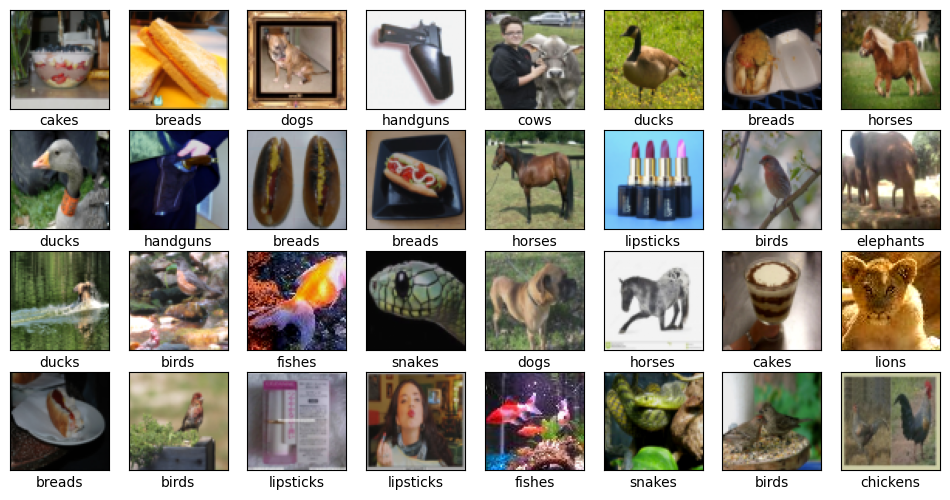

In [10]:
visualize_data(images, labels)

In [11]:
count_class = {}
for _,outs in dataset:
    labels = class_names[outs]
    if labels not in count_class:
        count_class[labels] = 0
    count_class[labels] += 1
count_class

{'birds': 512,
 'bottles': 432,
 'breads': 432,
 'butterflies': 500,
 'cakes': 432,
 'cats': 501,
 'chickens': 500,
 'cows': 500,
 'dogs': 501,
 'ducks': 496,
 'elephants': 500,
 'fishes': 500,
 'handguns': 448,
 'horses': 500,
 'lions': 500,
 'lipsticks': 400,
 'seals': 448,
 'snakes': 496,
 'spiders': 500,
 'vases': 368}

## Define Models

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
def compute_loss(model, loss_fn, loader):
  loss = 0
  # Set model to eval mode for inference
  model.eval()
  with torch.no_grad():  # No need to track gradients for validation
    for (batchX, batchY) in loader:
      # Move data to the same device as the model
      batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device).type(torch.long)
      loss += loss_fn(model(batchX), batchY)
  # Set model back to train mode
  model.train()
  return float(loss)/len(loader)

In [14]:
def compute_acc(model, loader):
    correct = 0
    totals = 0
    # Set model to eval mode for inference
    model.eval()
    for (batchX, batchY) in loader:
        # Move batchX and batchY to the same device as the model
        batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device)
        outputs = model(batchX)  # feed batch to the model
        totals += batchY.size(0)  # accumulate totals with the current batch size
        predicted = torch.argmax(outputs.data, 1)  # get the predicted class
        # Move batchY to the same device as predicted for comparison
        correct += (predicted == batchY).sum().item()
    return correct / totals

In [15]:
import time
def fit(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 50, verbose = True):
  # Move the model to the device before initializing the optimizer
  model.to(device)
  if optimizer == None:
    optim = torch.optim.Adam(model.parameters(), lr = 0.001) # Now initialize optimizer with model on GPU
  else:
    optim = optimizer
  history = dict()
  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()

  for epoch in range(num_epochs):
      start = time.time()
      model.train()
      for (X, y) in train_loader:
          # Move input data to the same device as the model
          X,y = X.to(device), y.to(device)
          # Forward pass
          outputs = model(X.type(torch.float32))
          loss = loss_fn(outputs, y.type(torch.long))
          # Backward and optimize
          optim.zero_grad()
          loss.backward()
          optim.step()
      #losses and accuracies for epoch
      val_loss = compute_loss(model, loss_fn, valid_loader)
      val_acc = compute_acc(model, valid_loader)
      train_loss = compute_loss(model, loss_fn, train_loader)
      train_acc = compute_acc(model, train_loader)
      history['val_loss'].append(val_loss)
      history['val_acc'].append(val_acc)
      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      end = time.time()
      print(f"total time for each epoch {end - start}") # time in seconds
      if not verbose: #verbose = True means we do show the training information during training
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
  return history

Here are some example CNNs for the demonstration purpose. You should use your own developed network for the competition.

In [16]:
class CnnModel(nn.Module):
	def __init__(self):
		super().__init__(num_classes=20)
		self.network = nn.Sequential(
			nn.Conv2d(3, 32, kernel_size=3, padding=1),
			nn.ReLU(),
			nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2, 2), # output: 64 x 48 x 48

			nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
			nn.ReLU(),
			nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2, 2), # output: 128 x 24 x 24

			nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
			nn.ReLU(),
			nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2, 2), # output: 256 x 12 x 12
			nn.Conv2d(256,512, kernel_size=3, stride=1, padding=1),
			nn.ReLU(),
			nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2, 2), # output: 512 x 6 x 6
			nn.Flatten(),
			nn.Linear(512*6*6, 1024),
			nn.ReLU(),
			nn.Linear(1024, 512),
			nn.ReLU(),
			nn.Linear(512, 20))

	def forward(self, xb):
		return self.network(xb)


def conv_block(in_channels, out_channels, pool=False):
	layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
			  nn.BatchNorm2d(out_channels),
			  nn.ReLU(inplace=True)]
	if pool: layers.append(nn.MaxPool2d(2))
	return nn.Sequential(*layers)

class ResNet9(nn.Module):
	def __init__(self, in_channels=3, num_classes=10):
		super().__init__()

		self.conv1 = conv_block(in_channels, 64,pool=True)
		self.conv2 = conv_block(64, 128, pool=True) # output: 128 x 24 x 24
		self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

		self.conv3 = conv_block(128, 256, pool=True) # output: 256 x 12 x 12
		self.conv4 = conv_block(256, 512, pool=True) # output: 512 x 6 x 6
		self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

		self.classifier = nn.Sequential(nn.MaxPool2d(6),
										nn.Flatten(),
										nn.Dropout(0.2),
										nn.Linear(512, num_classes))

	def forward(self, xb):
		out = self.conv1(xb)
		out = self.conv2(out)
		out = self.res1(out) + out
		out = self.conv3(out)
		out = self.conv4(out)
		out = self.res2(out) + out
		out = self.classifier(out)
		return out

class MiniVGG(nn.Module):
	def __init__(self, num_classes=20):
		super().__init__()
		layers = []
		layers.append(nn.Conv2d(3, 32, kernel_size=3, padding= 1)) #[32,32,32]
		layers.append(nn.BatchNorm2d(32))
		layers.append(nn.ReLU(inplace=True))
		#nn.LazyConv2d(32, kernel_size=3, padding=1),
		layers.append(nn.Conv2d(32, 32, kernel_size=3, padding=1)) #[32,32,32]
		layers.append(nn.BatchNorm2d(32))
		layers.append(nn.ReLU(inplace = True))
		layers.append(nn.MaxPool2d(kernel_size=2)) #down-sample by two #[32,16,16]
		layers.append(nn.Dropout(p=0.25))
		#nn.LazyConv2d(64, kernel_size=3, padding=1),
		layers.append(nn.Conv2d(32, 64 , kernel_size=3, padding=1)) #[64,16,16]
		layers.append(nn.BatchNorm2d(64))
		layers.append(nn.ReLU(inplace = True))
		#nn.LazyConv2d(64, kernel_size=3, padding=1)
		layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1)) #[64,16,16]
		layers.append(nn.BatchNorm2d(64))
		layers.append(nn.ReLU(inplace = True))
		layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1)) #[64,16,16]
		layers.append(nn.BatchNorm2d(64))
		layers.append(nn.ReLU(inplace= True)),
		layers.append(nn.MaxPool2d(kernel_size=2)), #down-sample by two [64,8,8]
		layers.append(nn.Dropout(p=0.25))
		layers.append(nn.Flatten(1)) #64x8x8
		layers.append(nn.LazyLinear(512))
		layers.append(nn.ReLU(inplace = True))
		layers.append(nn.LazyLinear(num_classes))
		self.block = nn.ModuleList(layers)
	def forward(self,x):
		for layer in self.block:
			x = layer(x)
		return x

## Training the Model

### Model Selection

In [17]:
#model = ResNet9().to(device)
model = MiniVGG(20).to(device)
# model = CnnModel().to(device)

#### <span style="color:#0b486b">4. Declaring the Loss, Optimizer, learning rate and Training the Model </span>

In [18]:
from torch import optim
optim_dict = {"Adam":optim.Adam, "Adadelta":optim.Adadelta, "Adagrad":optim.Adagrad,
              "Adamax":optim.Adamax, "AdamW": optim.AdamW, "ASGD":optim.ASGD,
              "NAdam":optim.NAdam, "RMSprop":optim.RMSprop, "RAdam":optim.RAdam,
              "Rprop": optim.Rprop, "SGD":optim.SGD}


# Loss and optimizer
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim_dict["Adam"](model.parameters(), lr=learning_rate)

#dnn_model = model
history = fit(model=model, train_loader=train_loader, valid_loader = val_loader,
    optimizer = optimizer, num_epochs= 2, verbose = False)

total time for each epoch 97.82705020904541
Epoch 1/2
train loss= 2.4230 - train acc= 25.95% - valid loss= 2.4699 - valid acc= 25.03%
total time for each epoch 96.19393014907837
Epoch 2/2
train loss= 2.1058 - train acc= 33.37% - valid loss= 2.1281 - valid acc= 32.84%


#### <span style="color:#0b486b">5. Visualizing the Performance and Loss Objective Function </span>

There are four keys in the history dictionary: `train_loss` and `val_loss` measure the loss on the training set and the validation set, respectively, while `train_acc` and `val_acc` measure the accuracy on the training set and the validation set.  
The following figure visualize all four metrics with two y-axes, losses (blue lines, in descending) and accuracies (red lines, in asending)


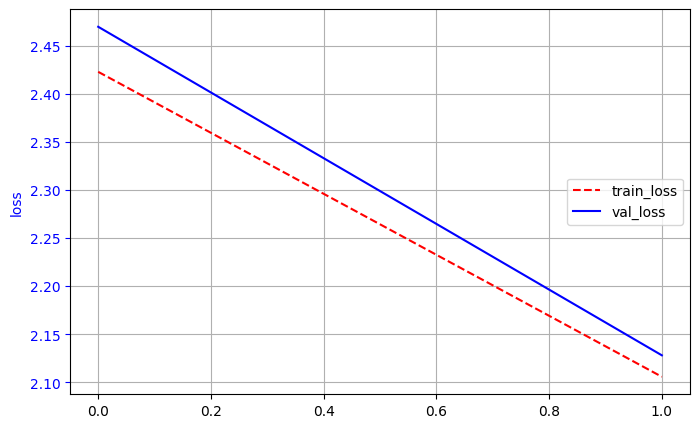

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

his = history
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ln1 = ax.plot(his['train_loss'], 'r--',label='train_loss')
ln2 = ax.plot(his['val_loss'], 'b-',label='val_loss')
ax.set_ylabel('loss', color='blue')
ax.tick_params(axis='y', colors="blue")

lns = ln1 + ln2
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc=7)
plt.grid(True)
plt.show()

# Evaluate model on the testing set, get the csv file and upload to kaggle website.

In [20]:
!gdown --fuzzy https://drive.google.com/file/d/1gntVodsAzZntMb1qW2UCns-RdpckfQh0/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1gntVodsAzZntMb1qW2UCns-RdpckfQh0
From (redirected): https://drive.google.com/uc?id=1gntVodsAzZntMb1qW2UCns-RdpckfQh0&confirm=t&uuid=148d9c48-1651-451c-80ed-7654512ae3bc
To: /kaggle/working/test_set.zip
100%|██████████████████████████████████████| 28.9M/28.9M [00:01<00:00, 16.8MB/s]


In [21]:
!unzip -q test_set.zip

In [22]:
test_data_dir = "./test_set"

# We resize the images to [3,64,64]
transform = transforms.Compose([transforms.Resize((64,64)),  #resises the image so it can be perfect for our model.
                                      #transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      #transforms.RandomRotation(4),     #Rotates the image to a specified angel
                                      #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # convert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images, each R,G,B value is normalized with mean=0.5 and std=0.5
                                      ])


# Load the dataset using torchvision.datasets.ImageFolder and apply transformations
testset = datasets.ImageFolder(test_data_dir, transform=transform)

print("Number of instance in test_set: %s" % len(testset))

test_loader = DataLoader(testset, batch_size=500, shuffle=False)


Number of instance in test_set: 16167


In [23]:
import torch
import pandas as pd

def save_prediction_to_csv(model, loader, device, output_file="submission.csv"):
    model.eval()
    predictions = []
    image_ids = []
    df = {
    "ID": [],
    "Label": []
    }
    total = 0
    with torch.no_grad():
        for i, (batchX, batchY) in enumerate(loader):
            batchX, batchY = batchX.to(device), batchY.to(device)
            outputs = model(batchX.float())  # Convert to float32 and feed batch to the model
            predicted = torch.argmax(outputs, dim=1)  # Get the predicted class
            total += predicted.size(0)
            for ids, pred in enumerate(predicted):
                label = class_names[pred.to(device).item()]
                df["ID"].append(i*500+ids)
                df["Label"].append(label)
    df["ID"] = [i for i in range(total)]
    # Create a DataFrame
    df = pd.DataFrame(df)
    # Save to CSV
    df.to_csv(output_file, index=False)

In [24]:
save_prediction_to_csv(model, test_loader, device)

# Upload result to kaggle competition

## Regsiter Kaggle account using your private gmail
## Join the competition
## Upload the submission.csv file to the kaggle website to get your results